# Baseline Modeling - Regression

---

* Goal: to develop baseline models prior to feature engineering to compare performance vs. post-engineered models.

My goal with this notebook is to develop a series of baseline models using minimal preprocessing. These models will establish a baseline performance for me to improve with additional feature engineering. Additionally, the most impactful features for each model can indicate if there are any features that are too strongly predictive.

---

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv

In [24]:
## SKLearn and Modeling Tools

from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.pipeline import Pipeline as fePipeline

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

set_config(transform_output='pandas')

## Load Data

In [25]:
df_data = pd.read_feather('../../data/source/full_data.feather')
# df_data = df_data.set_index('UUID')
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,UUID
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1502832c-f9fe-4c2b-a7be-cce3a85d5441
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2f85c742-d1c8-44fb-84da-c6e3dbc039a2
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,cbe1e6ae-2b44-4de2-a634-72356a93617a
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,5a29a4bd-5718-425f-953e-0e18f3ff1d29
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,a020d6df-bcba-45ea-a1d7-02688d117fbc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,56bcbcf2-ef31-4986-bd3a-71a5f0257e37
79326,0,102,2017,August,35,31,2,5,3,0.0,...,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,07fdd8a6-059a-4441-beb0-0f73f7e71faa
79327,0,34,2017,August,35,31,2,5,2,0.0,...,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,c3d83a7c-8c2e-4233-a8e0-9b1f39bf989d
79328,0,109,2017,August,35,31,2,5,2,0.0,...,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,bbd4055e-9d03-48e7-b4de-fc0a3b047a14


## Set Target Feature

In [26]:
target_feature = 'ADR'

## Quick Overview

                                             |          | [  0%]   00:00 -> (? left)


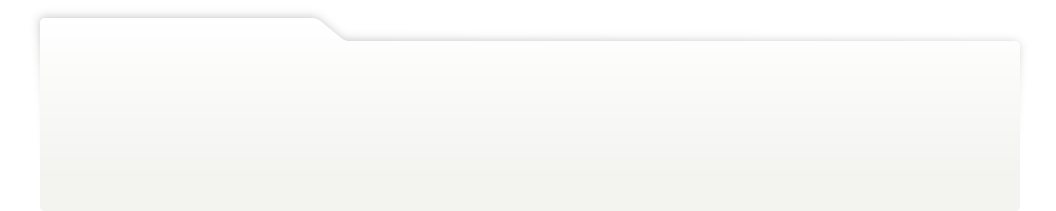
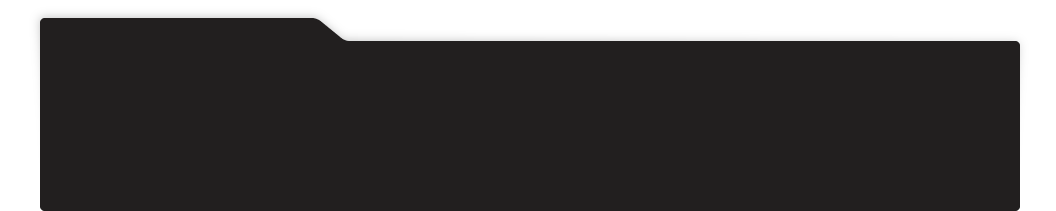
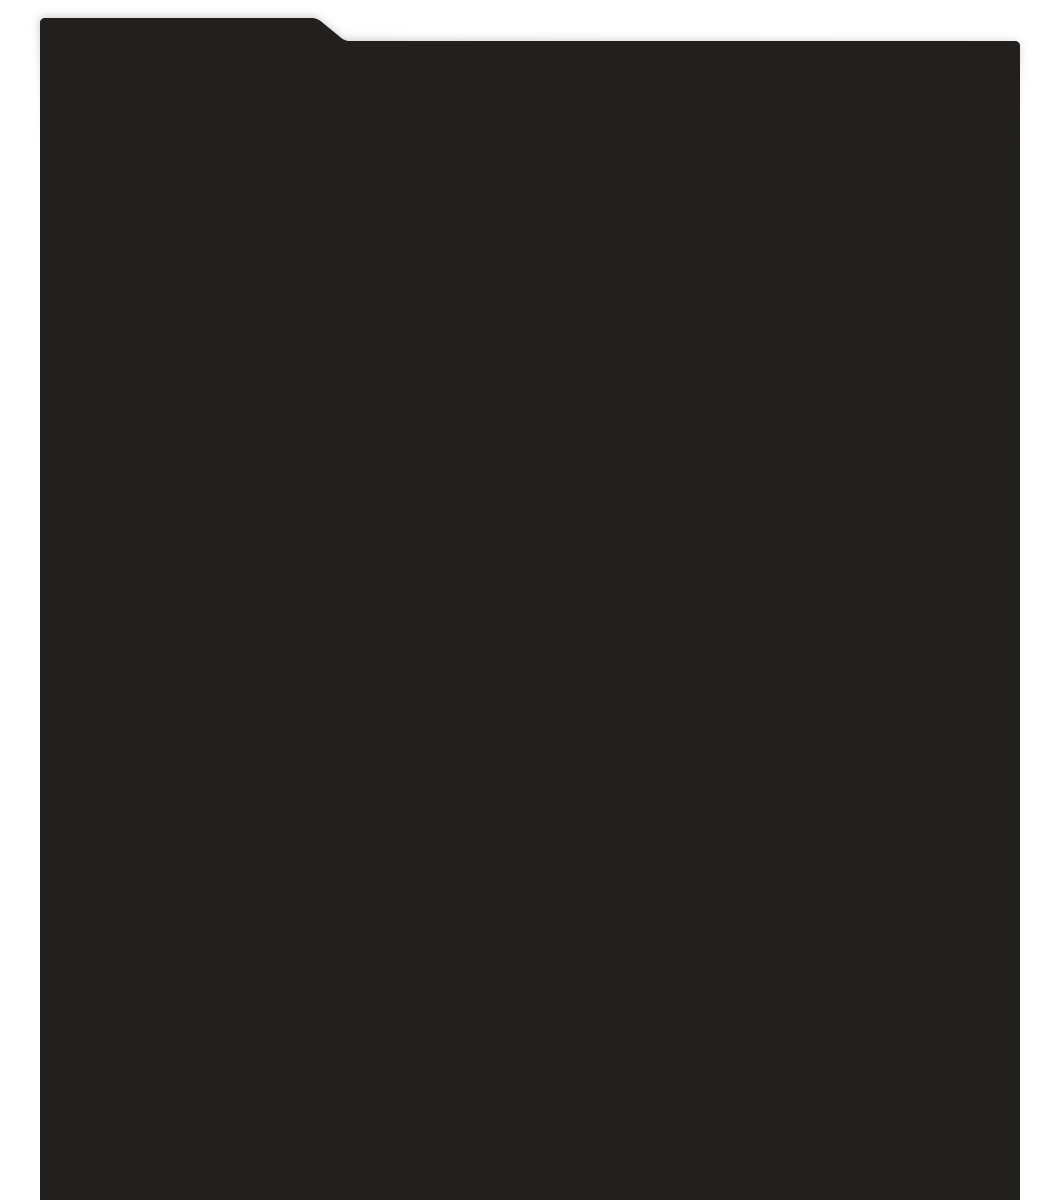
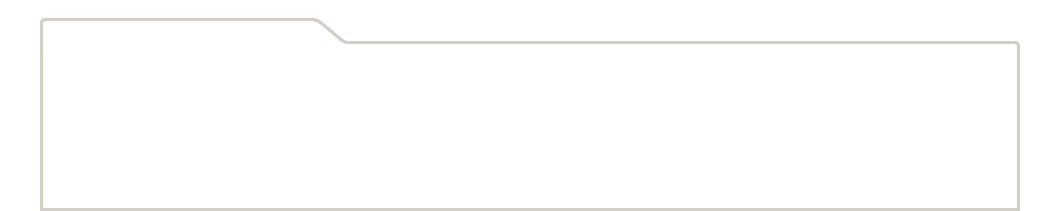
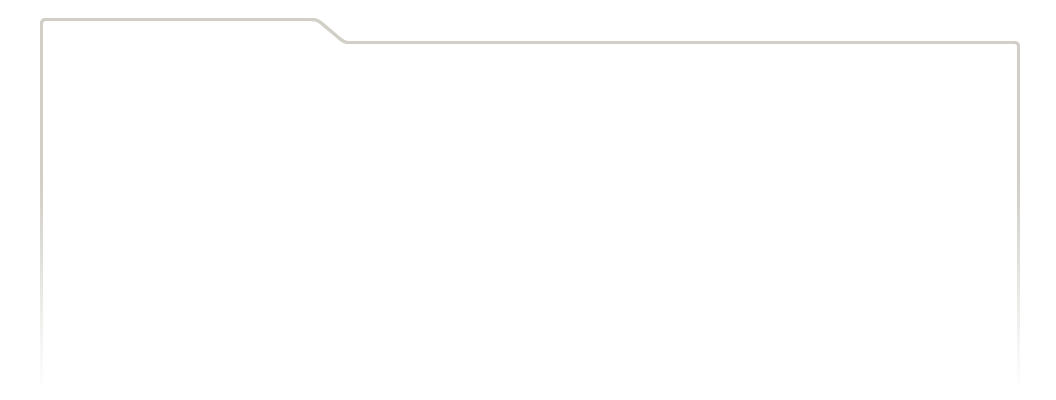
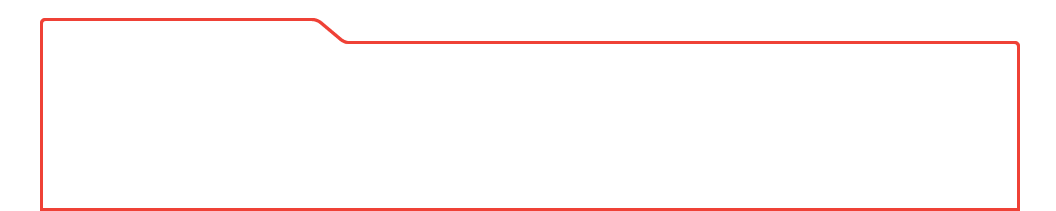
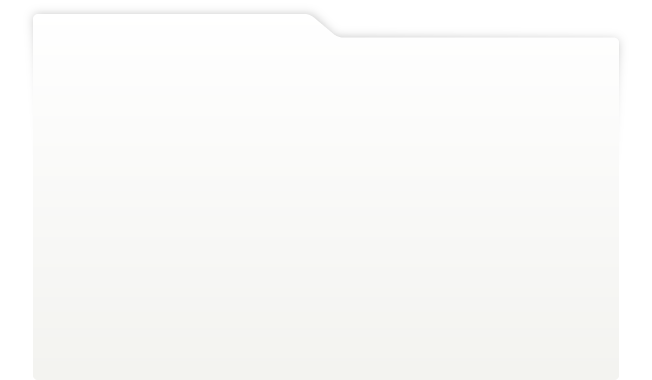
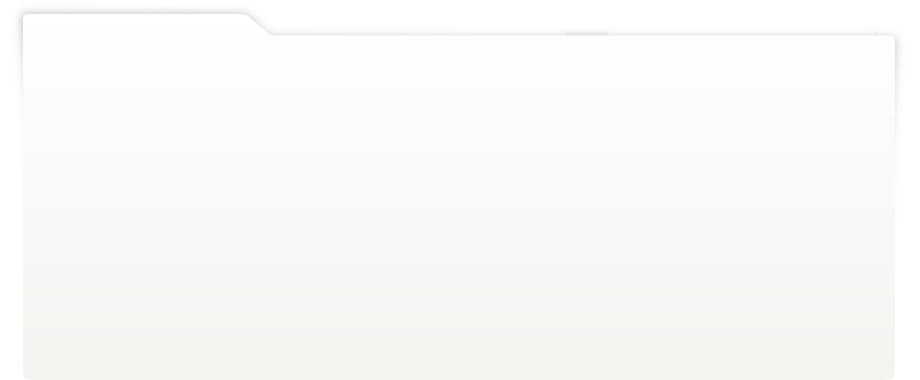
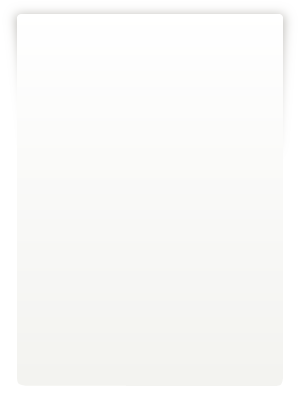
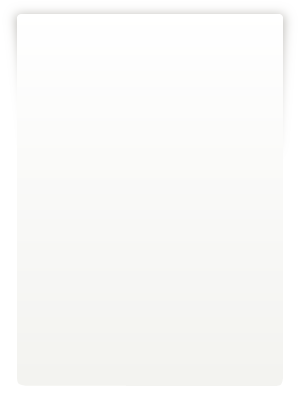
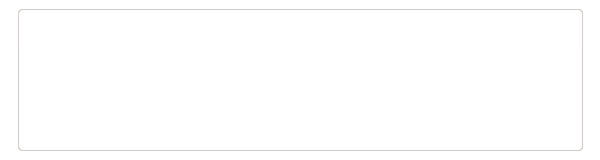
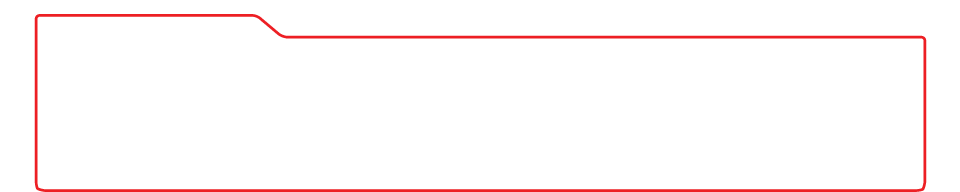
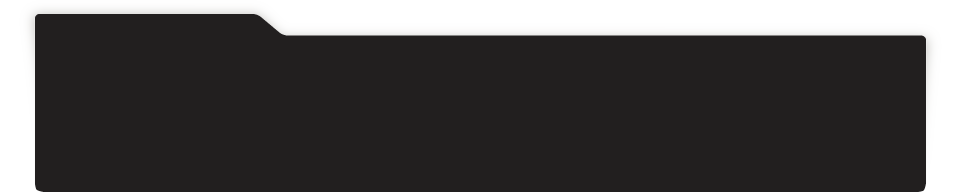
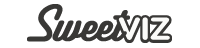
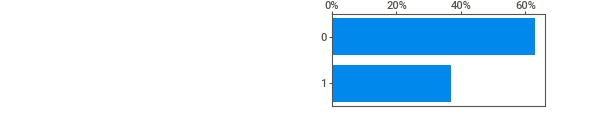
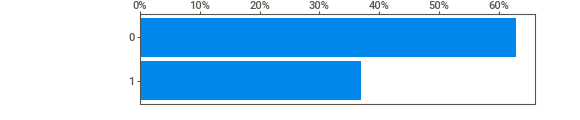
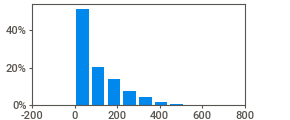
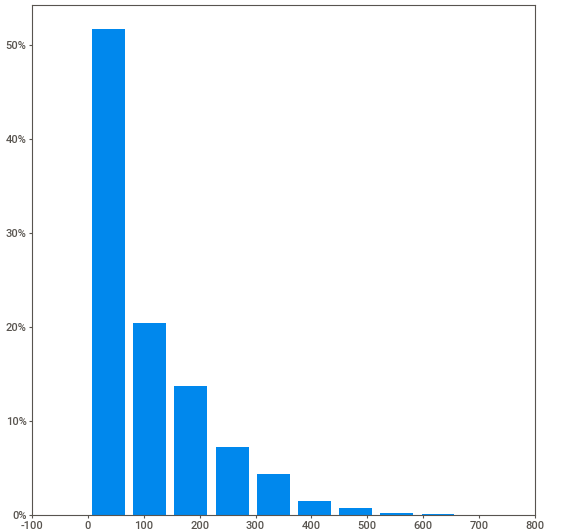
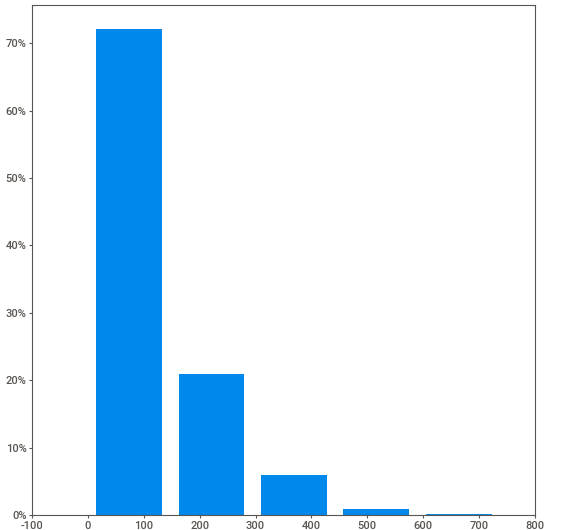
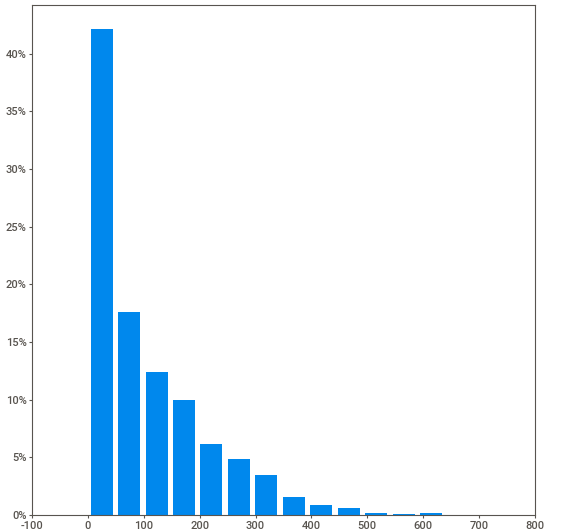
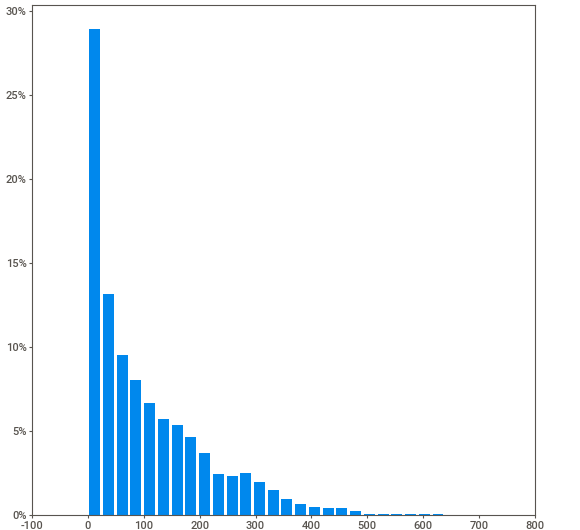
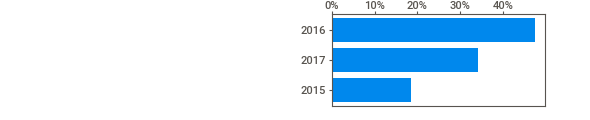
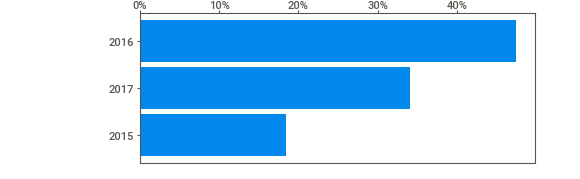
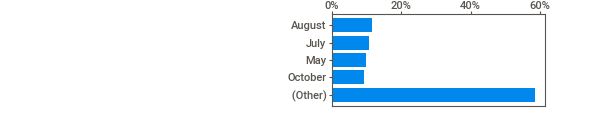
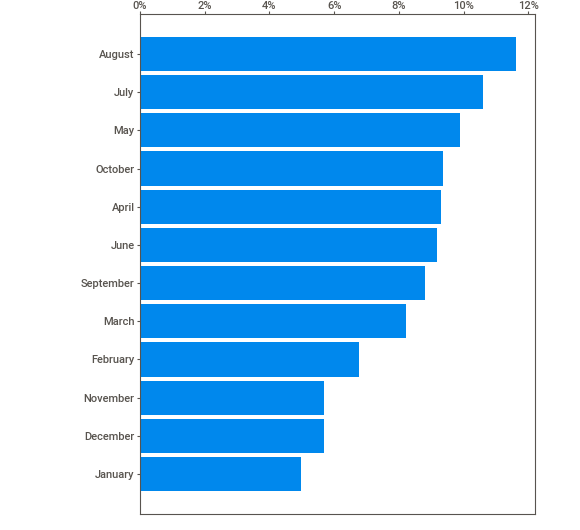
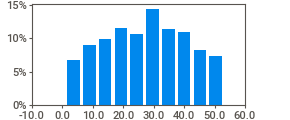
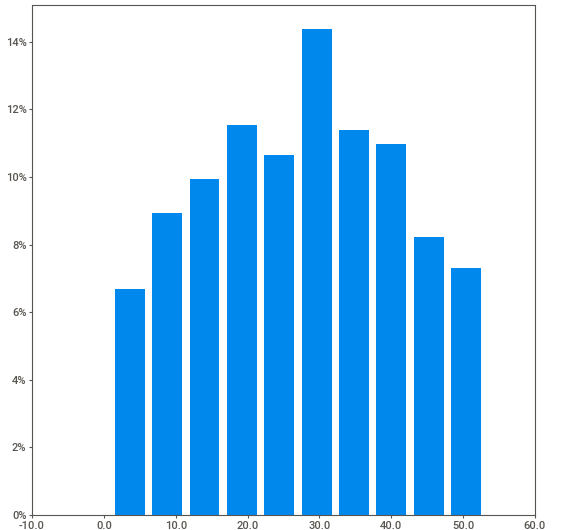
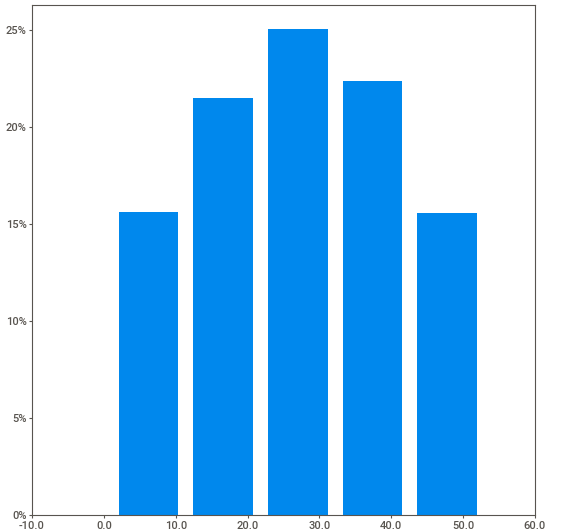
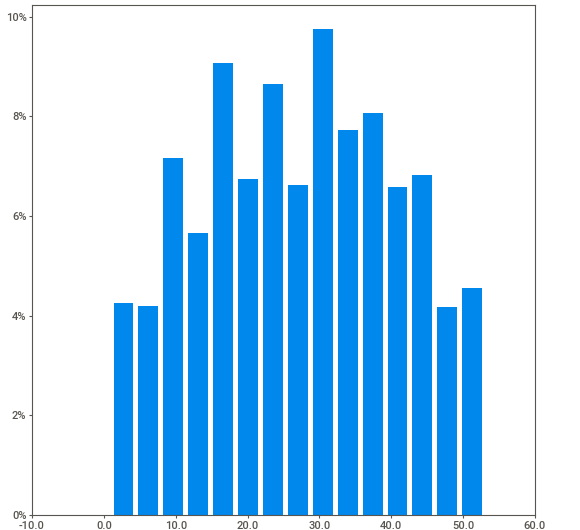
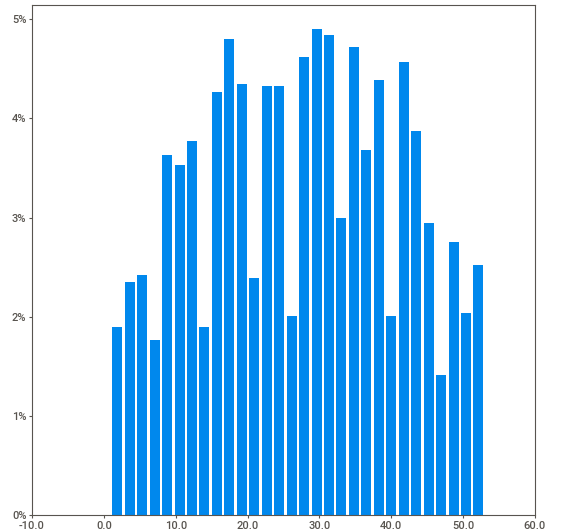
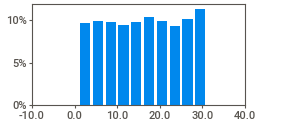
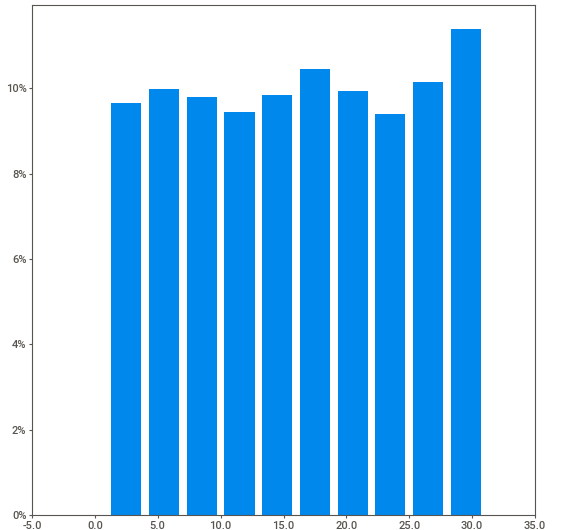
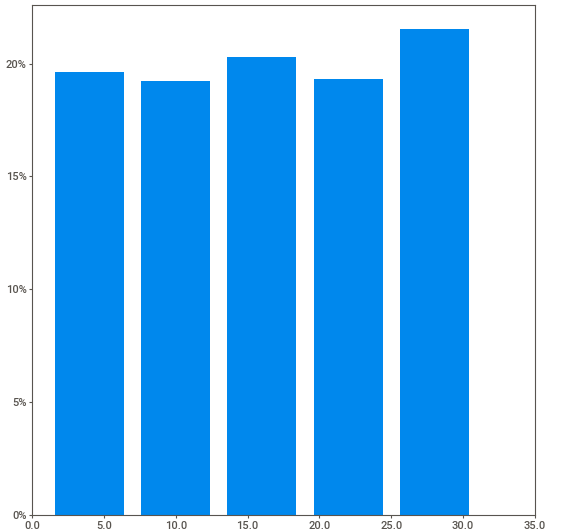
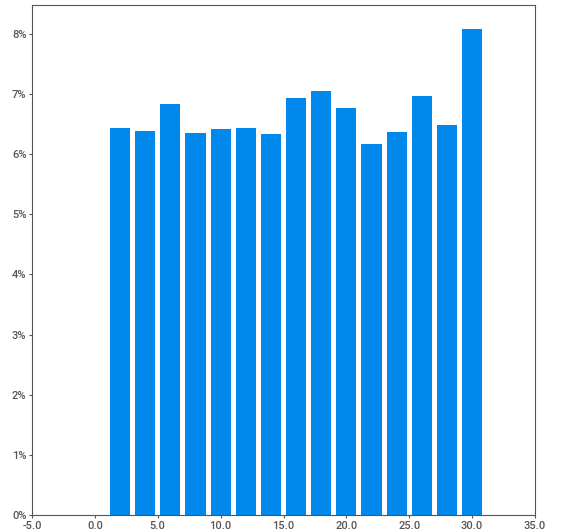
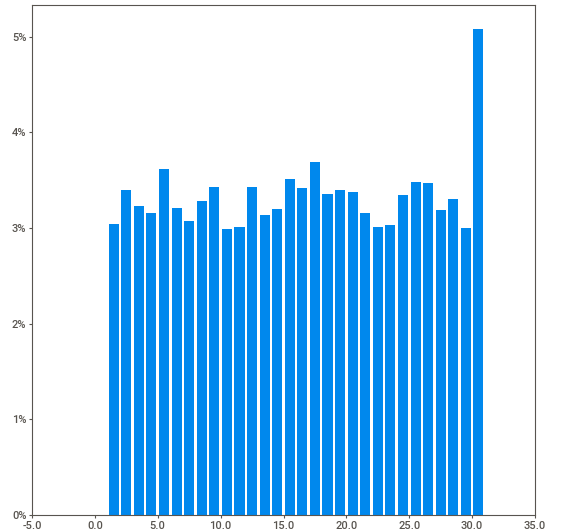
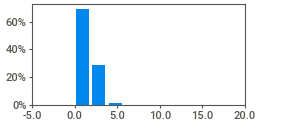
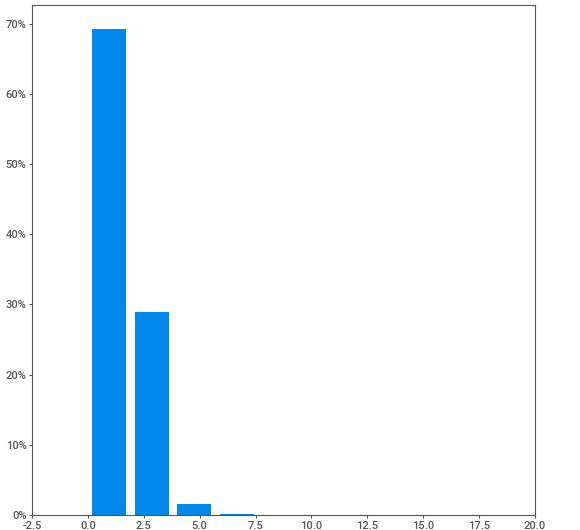
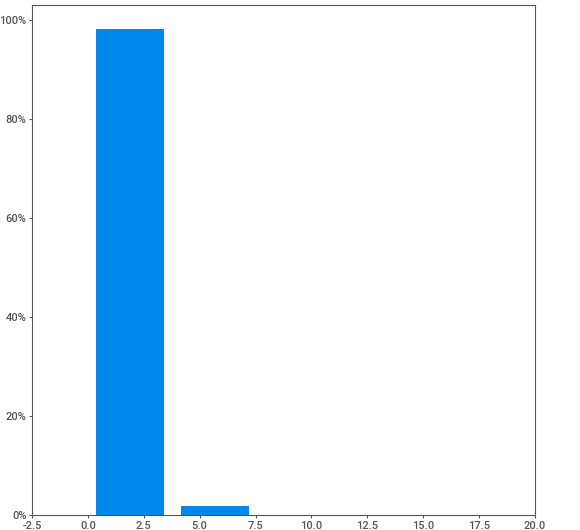
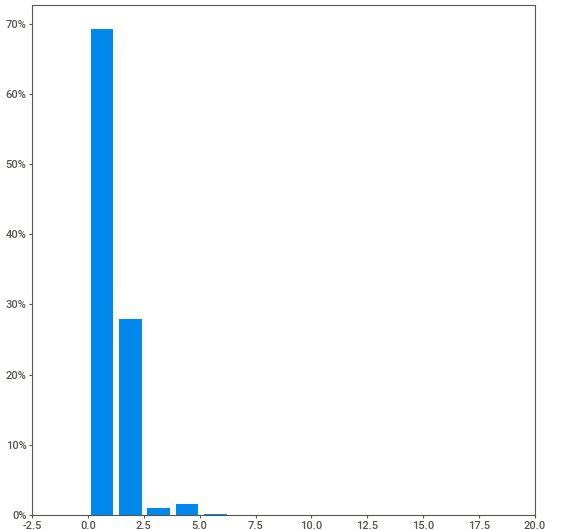
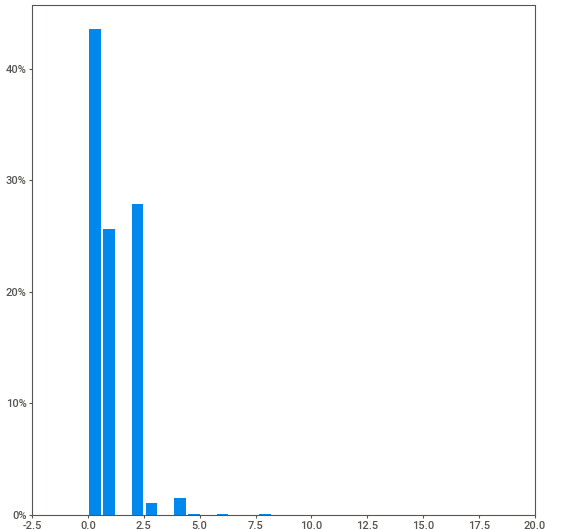
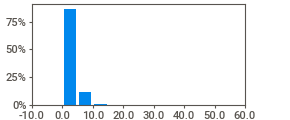
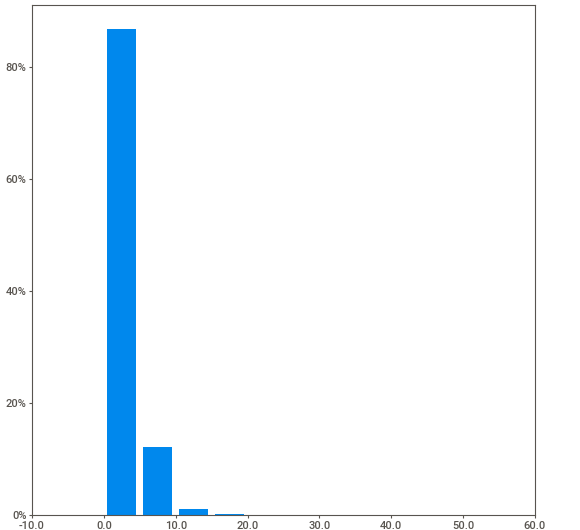
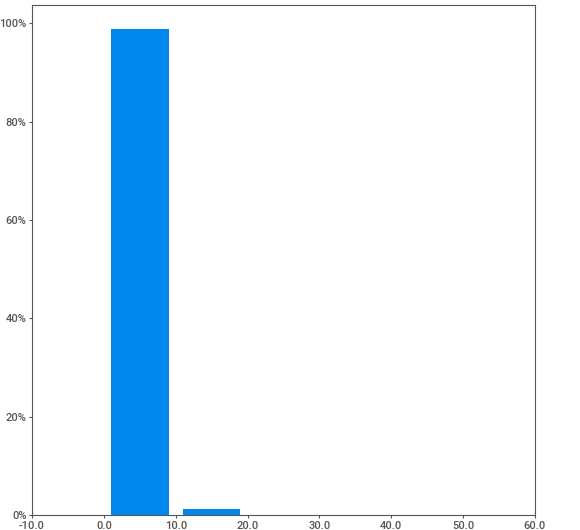
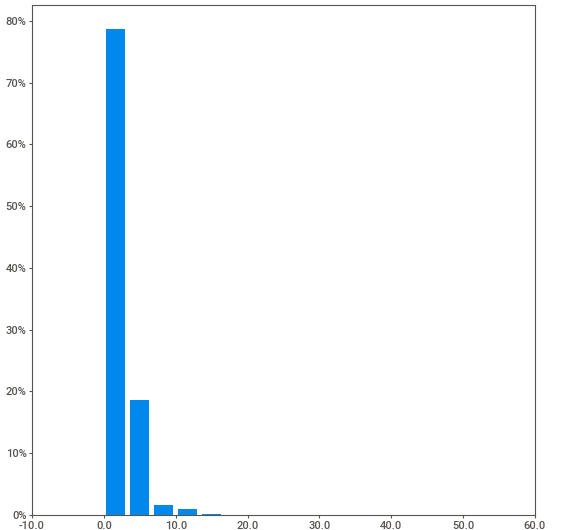
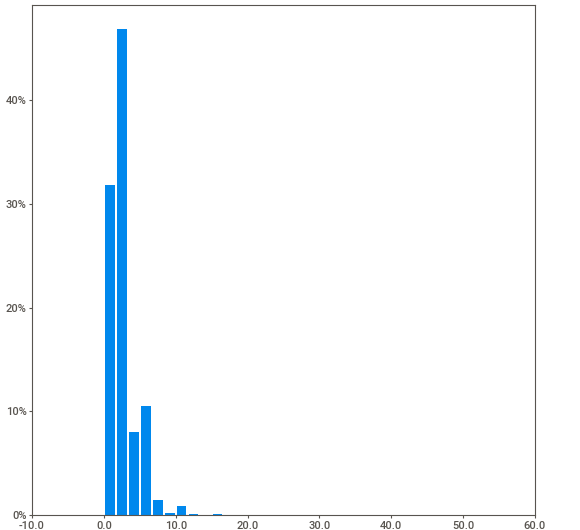
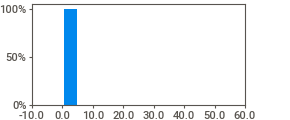
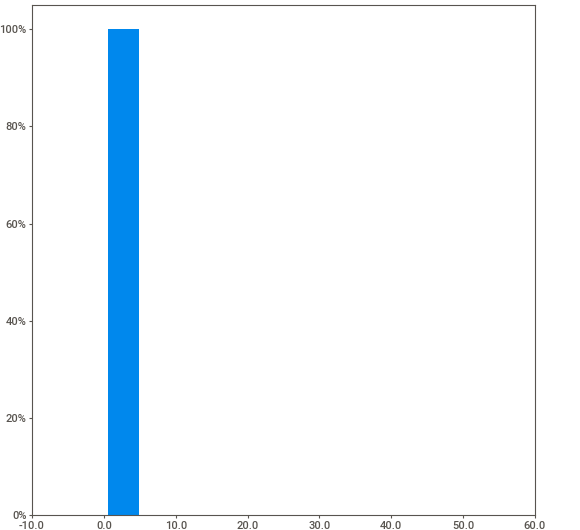
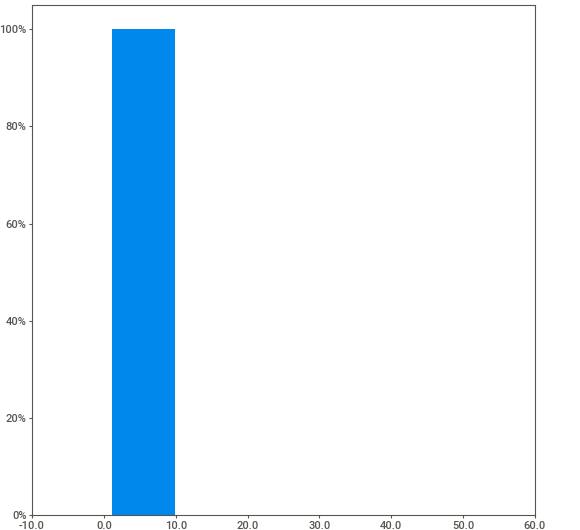
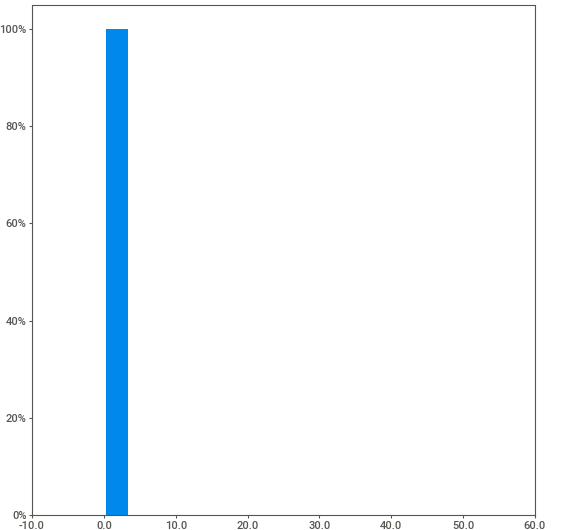
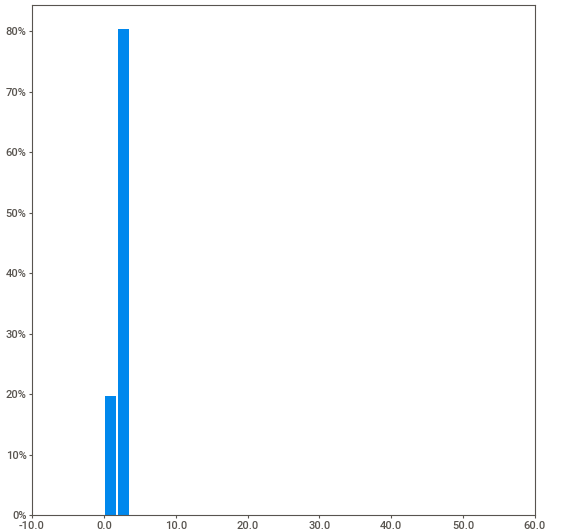
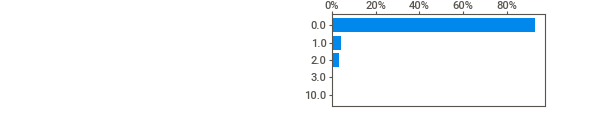
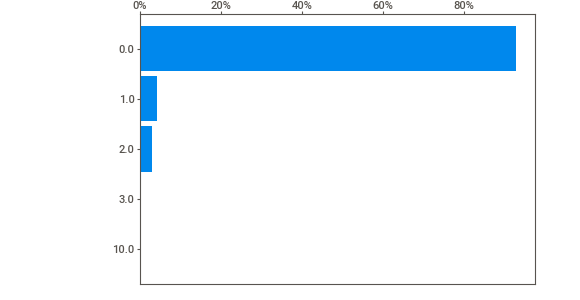
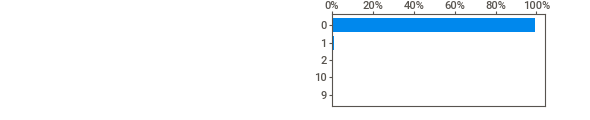
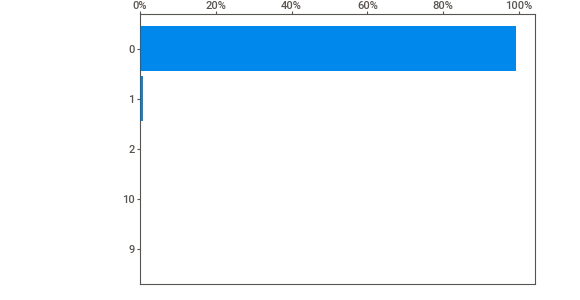
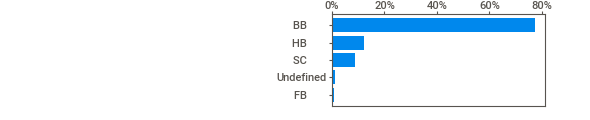
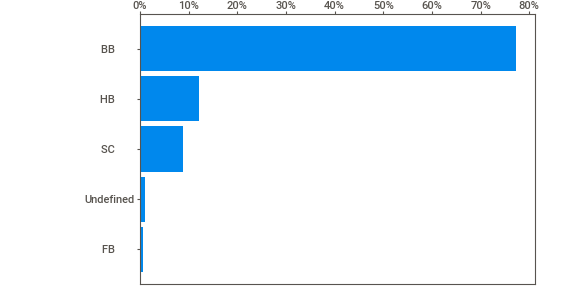
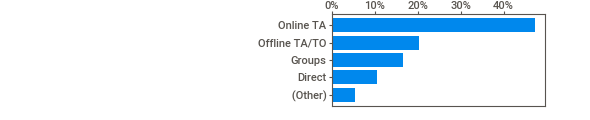
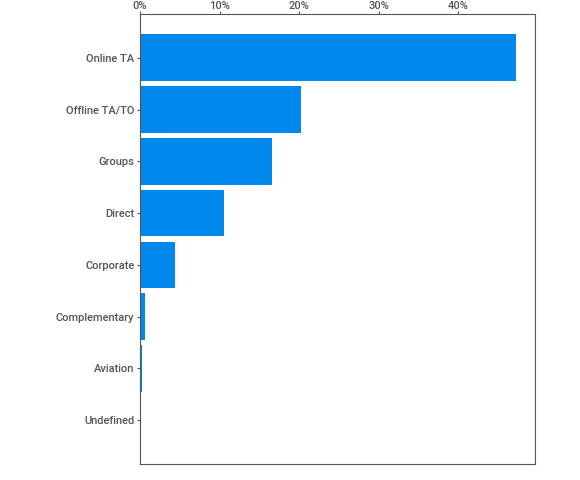
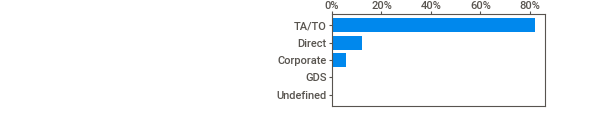
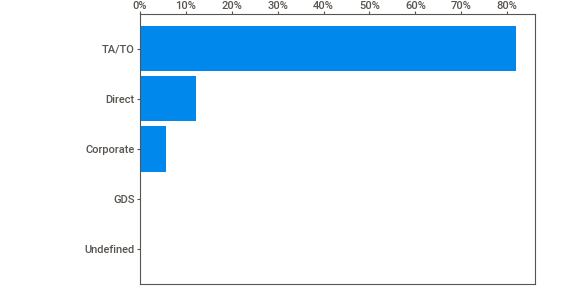
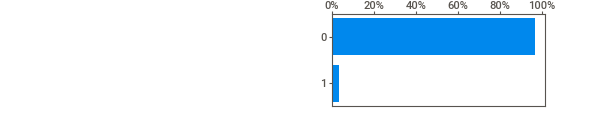
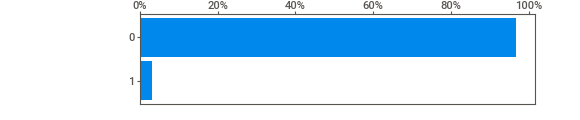
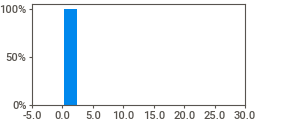
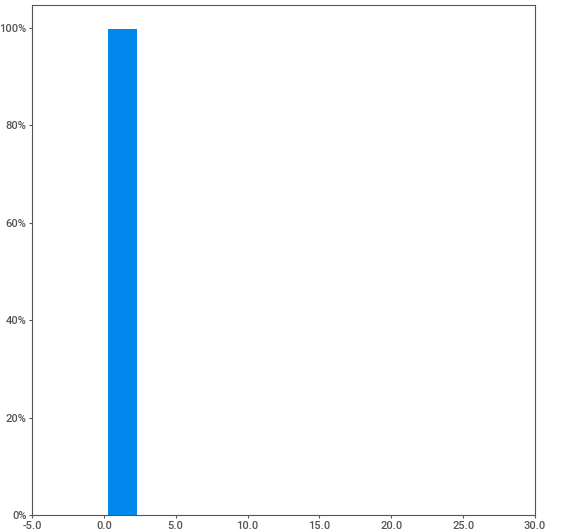
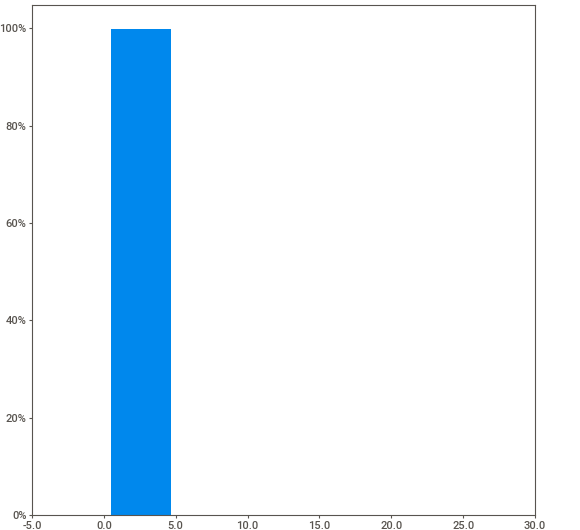
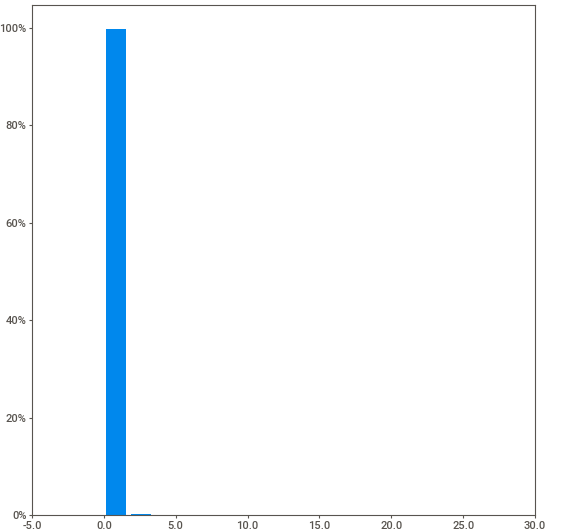
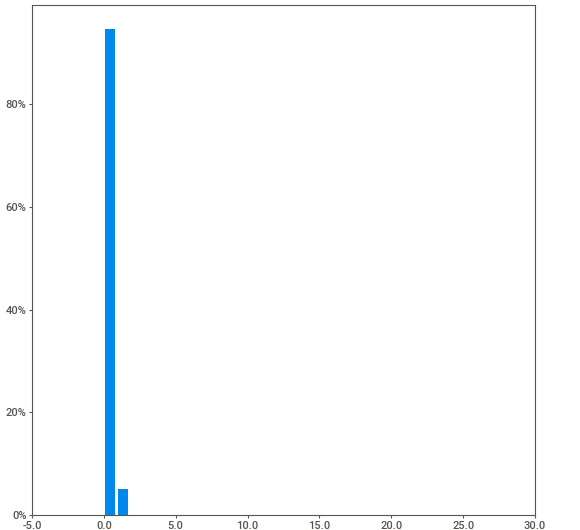
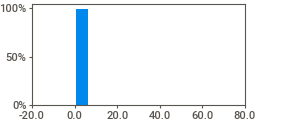
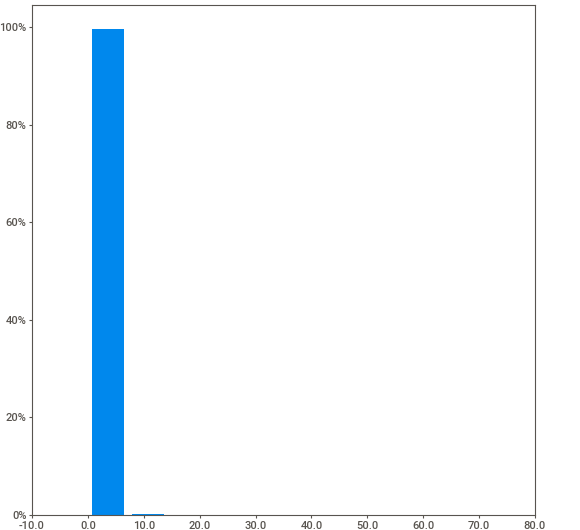
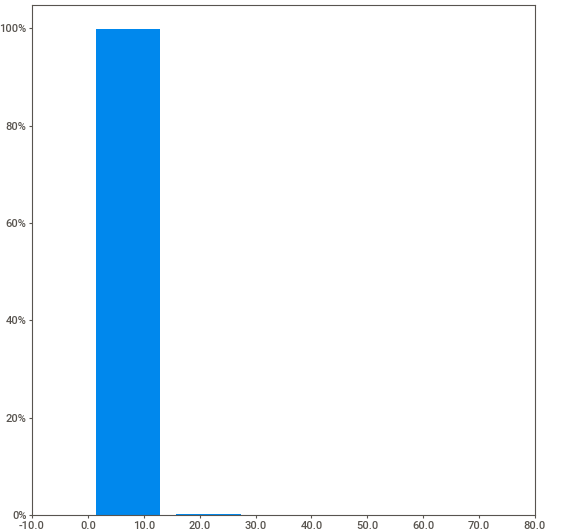
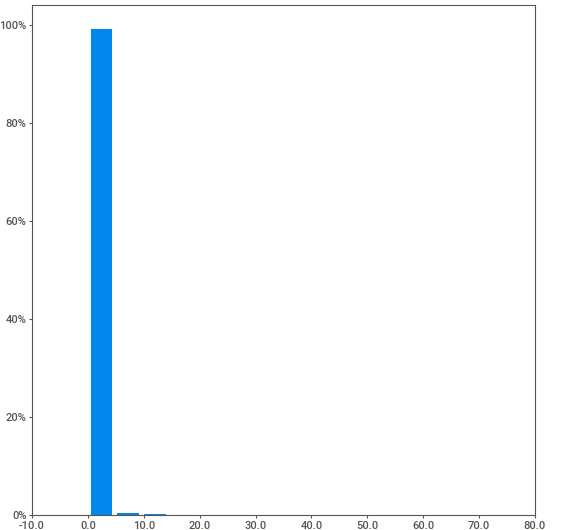
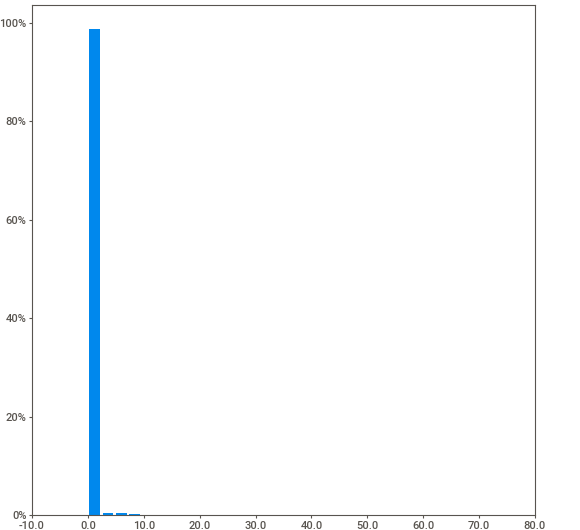
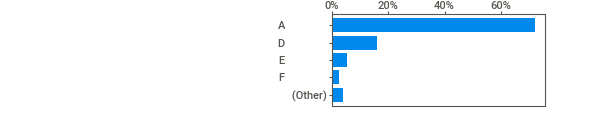
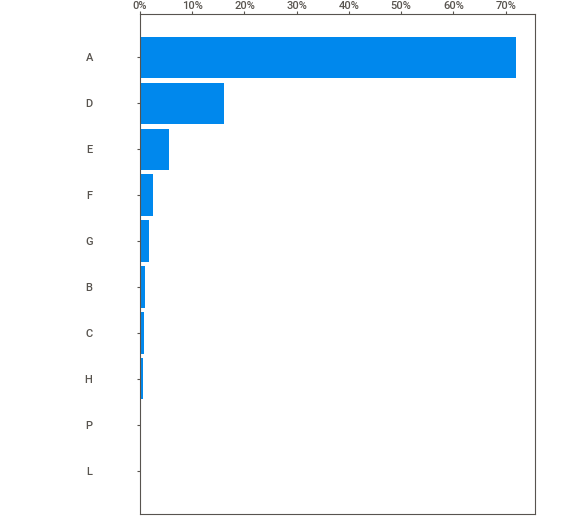
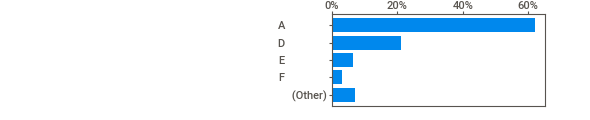
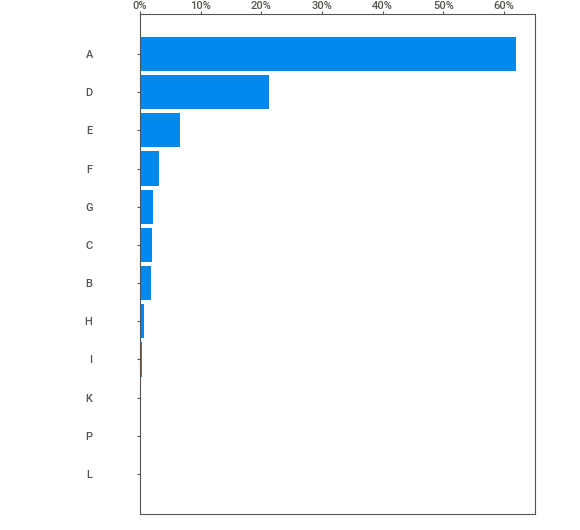
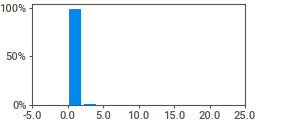
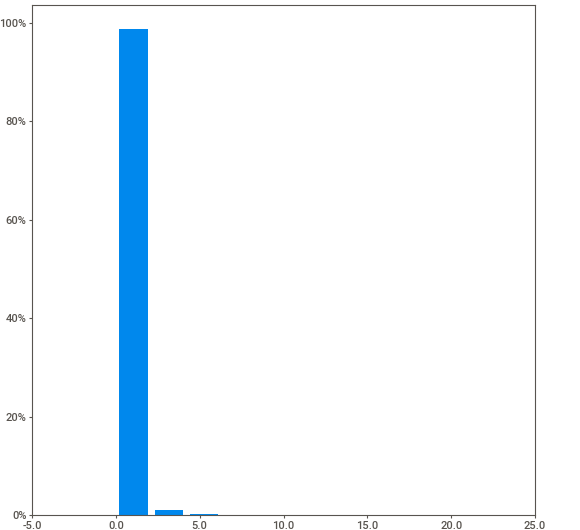
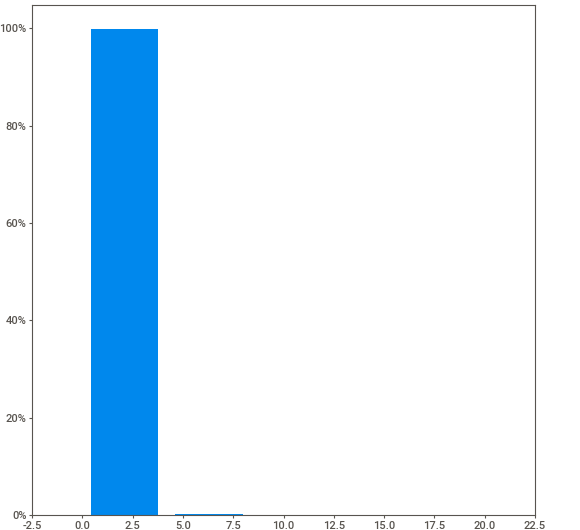
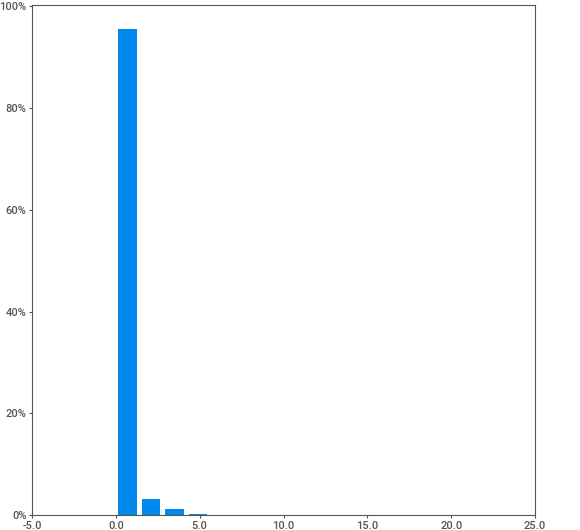
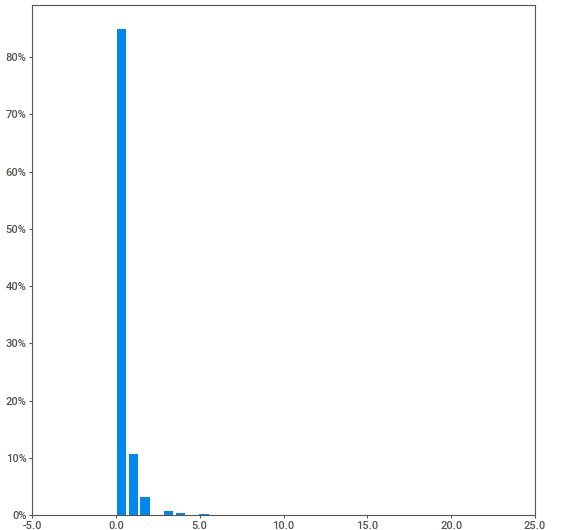
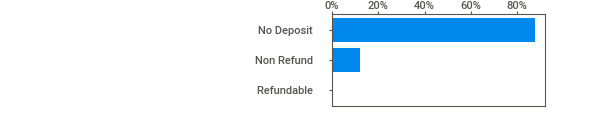
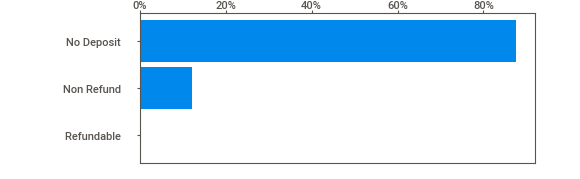
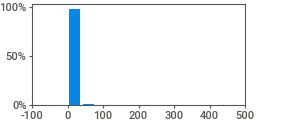
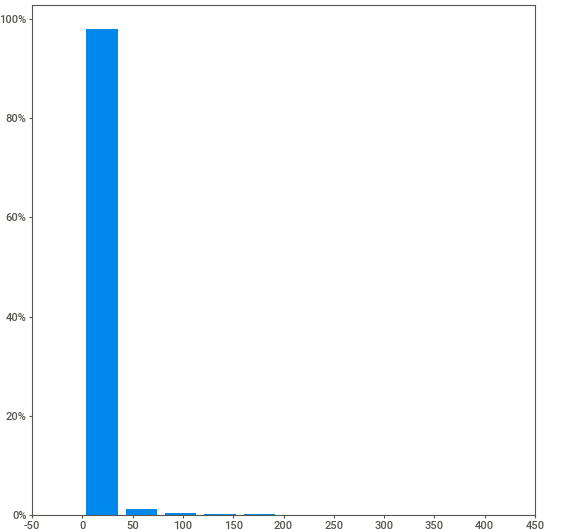
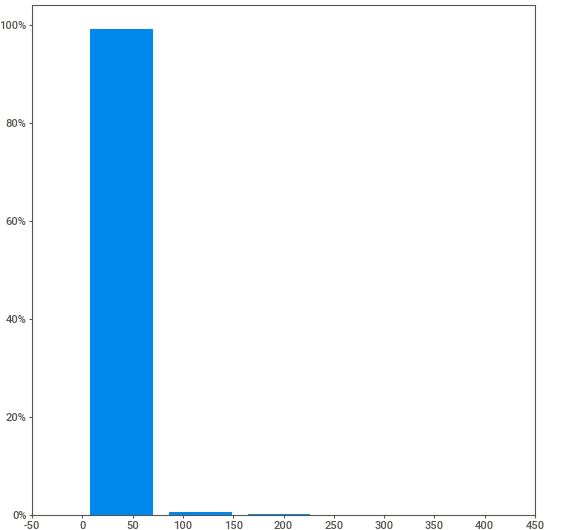
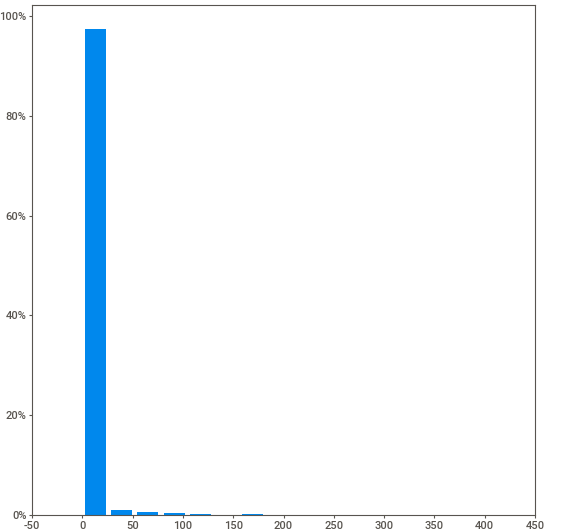
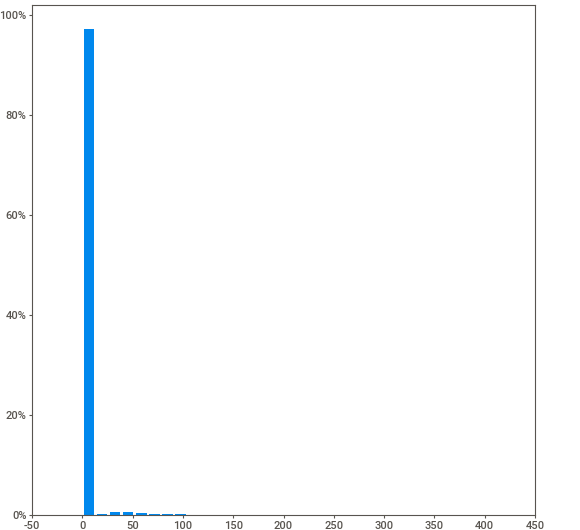
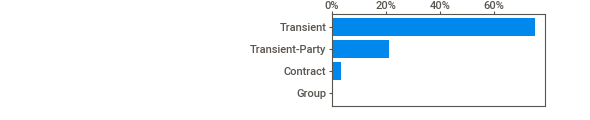
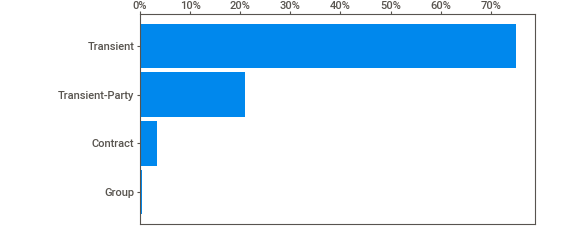
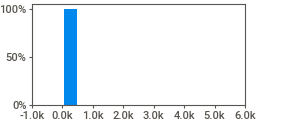
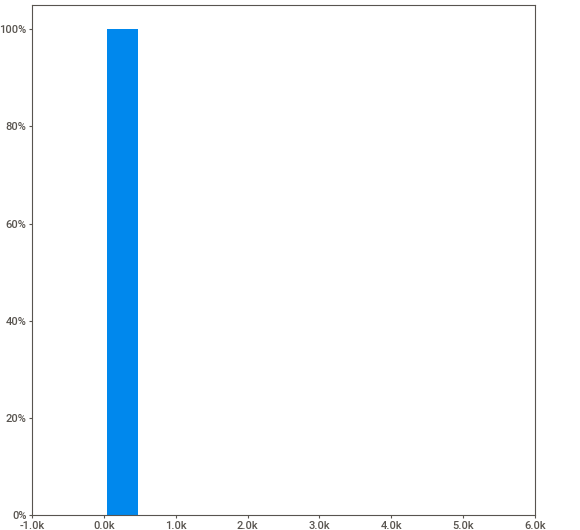
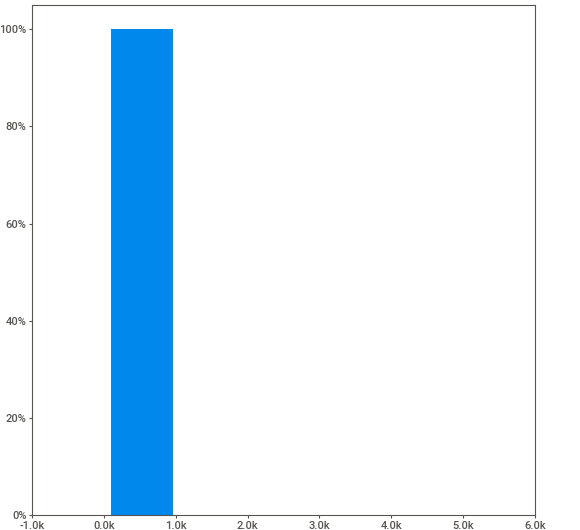
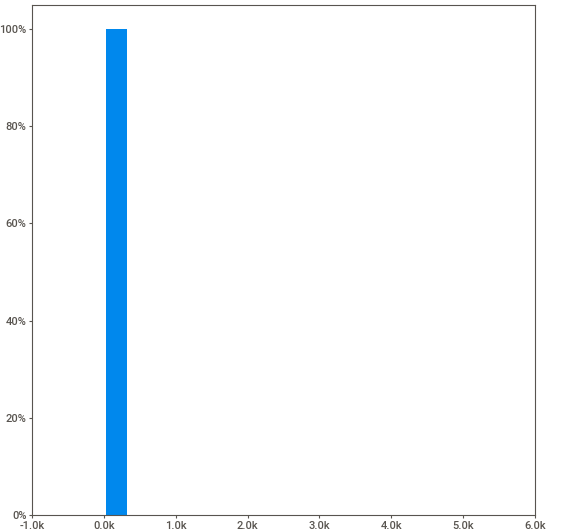
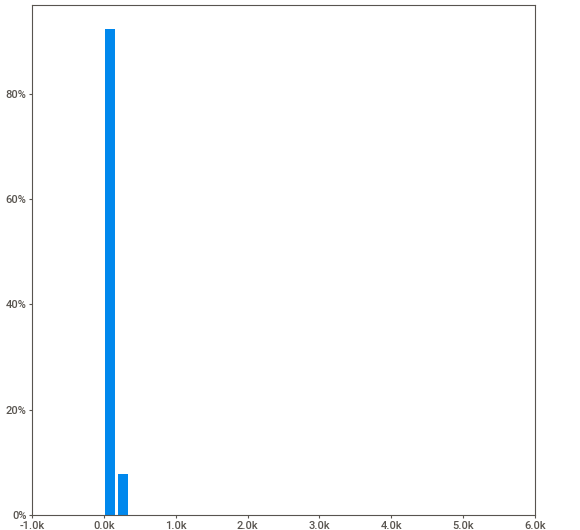
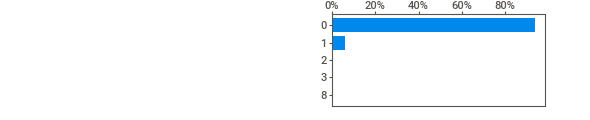
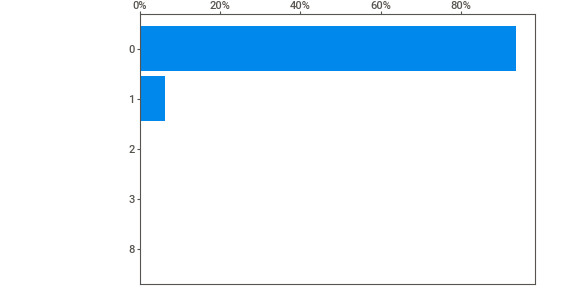
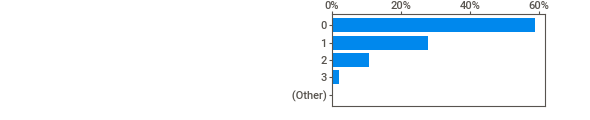
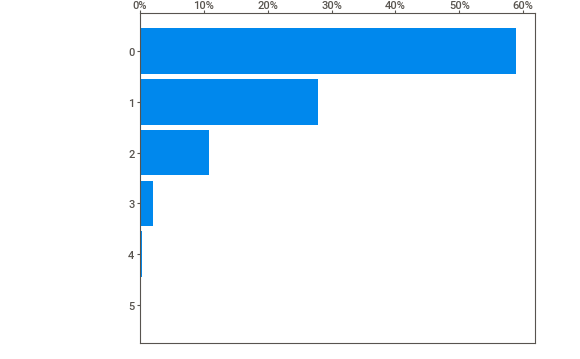
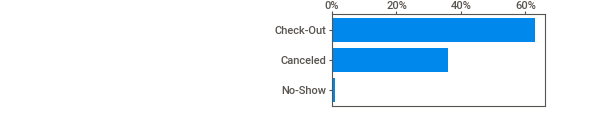
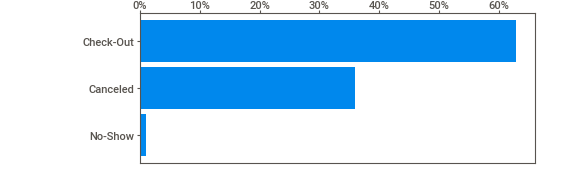

In [27]:
sv.analyze(df_data,pairwise_analysis = 'off').show_notebook()

---

**Quick Overview: Review**

Based on the quick EDA, I see there are both categorical features (several with high cardinality) and continuous (with right-tailed skews and some extreme outliers).

**Questionable Features**

First, I will drop the column `UUID` as it is a unique identifier and does not have any predictive value.

There are two features that I can identify from domain knowledge as being too strongly predictive of the ADR (`IsCanceled`, `ReservationStatus`). These features indicate whether or not a guest stayed (if they cancel or no-show, the revenue is zero).

Additionally, there are some temporal features that are either irrelevant to predictive modeling (`ArrivalDateYear`) or too closely related to the predictive features above (`ReservationStatusDate`).

I will drop these features to match real-world data more closely/realistically.

---

In [28]:
df_data = df_data.drop(columns = ['UUID', 'IsCanceled',
                                  'ReservationStatus',
                                  'ReservationStatusDate',
                                  'ArrivalDateYear'])

In [29]:
df_data.head().T

,0,1,2,3,4
LeadTime,342,737,7,13,14
ArrivalDateMonth,July,July,July,July,July
ArrivalDateWeekNumber,27,27,27,27,27
ArrivalDateDayOfMonth,1,1,1,1,1
StaysInWeekendNights,0,0,0,0,0
StaysInWeekNights,0,0,1,1,2
Adults,2,2,1,1,2
Children,0.0,0.0,0.0,0.0,0.0
Babies,0,0,0,0,0
Meal,BB,BB,BB,BB,BB


# Train-Test Split and Preprocessor

In [30]:
df_data.head()

,LeadTime,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,...,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,342,July,27,1,0,0,2,0.0,0,BB,...,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0
1,737,July,27,1,0,0,2,0.0,0,BB,...,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0
2,7,July,27,1,0,1,1,0.0,0,BB,...,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0
3,13,July,27,1,0,1,1,0.0,0,BB,...,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0
4,14,July,27,1,0,2,2,0.0,0,BB,...,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1


In [31]:
X = df_data.drop(columns = target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 903)

# Create Feature-Engine Pipeline

In [32]:
# ## Convert Series to DataFrame for transformation
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

# # Define the target transformer and transform the target
# target_transformer = PowerTransformer(method='yeo-johnson')
# y_train = target_transformer.fit_transform(y_train)
# y_test = target_transformer.transform(y_test)

# y_train = y_train['ADR']
# y_test = y_test['ADR']

In [41]:
# cat_feats = X.select_dtypes('object').columns
# num_feats = X.select_dtypes('number').columns

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent', )),
#                          ('encoder', MeanEncoder(missing_values = 'ignore',
#                                                  unseen = 'encode',
#                                                  smoothing=10))])

# num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
#                          ('powertransformer', PowerTransformer(method = 'yeo-johnson')),
#                          ('scaler', StandardScaler())])

# ## Combine transformers into a single ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
#                                                ('cat', cat_pipeline, cat_feats)
#                                                ])

# ## Define the target transformer
# target_transformer = PowerTransformer(method='yeo-johnson')

# ## Instantiate the model
# base_regressor = RandomForestRegressor(n_jobs = -1,
#                                   random_state = 903,)

# # Create the TransformedTargetRegressor with Yeo-Johnson transformation
# regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# # Build the pipeline
# model_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', regressor)
# ])

In [40]:
# cat_feats = X.select_dtypes('object').columns
# num_feats = X.select_dtypes('number').columns

# # cat_pipeline = fePipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
# #                            ('encoder', CountFrequencyEncoder(encoding_method = 'frequency',
# #                                                              unseen = 'encode',
# #                                                              missing_values = 'ignore'))])

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent', )),
#                          ('encoder', MeanEncoder(missing_values = 'ignore',
#                                                  unseen = 'encode',
#                                                  smoothing=10))])

# num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
#                          ('powertransformer', PowerTransformer(method = 'yeo-johnson')),
#                          ('scaler', StandardScaler())])

# ## Combine transformers into a single ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
#                                                ('cat', cat_pipeline, cat_feats)
#                                                ])

# ## Define the target transformer
# target_transformer = PowerTransformer(method='yeo-johnson')

# ## Instantiate the model
# base_regressor = RandomForestRegressor(n_jobs = -1,
#                                   random_state = 903,)

# # Create the TransformedTargetRegressor with Yeo-Johnson transformation
# regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# # regressor = base_regressor



# # # Select categorical and numerical features
# # cat_feats = X.select_dtypes('object').columns
# # num_feats = X.select_dtypes('number').columns

# # cat_pipeline = fePipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
# #                            ('encoder', CountFrequencyEncoder(encoding_method = 'frequency',
# #                                                              unseen = 'encode',
# #                                                              missing_values = 'ignore'))])

# # cat_pipeline = Pipeline([
# #     ('imputer', SimpleImputer(strategy = 'most_frequent')),
# #     ('encoder', MeanEncoder(missing_values = 'ignore',
# #                             unseen = 'encode',
# #                             smoothing=10))])

# # # Define the numerical pipeline
# # num_pipeline = Pipeline([
# #     ('imputer', SimpleImputer(strategy='mean')),
# #     ('powertransformer', PowerTransformer(method='yeo-johnson')),
# #     ('scaler', StandardScaler())
# # ])

# # # Combine transformers into a single ColumnTransformer
# # preprocessor = ColumnTransformer(transformers=[
# #     ('num', num_pipeline, num_feats),
# #     ('cat', cat_pipeline, cat_feats)
# # ])

# # # Define the target transformer
# # target_transformer = PowerTransformer(method='yeo-johnson')

# # # Instantiate the model
# # base_regressor = RandomForestRegressor(n_jobs=-1, random_state=903, min_samples_split=2, min_samples_leaf=2)

# # # Create the TransformedTargetRegressor with Yeo-Johnson transformation
# # regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# # Build the pipeline
# model_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', regressor)
# ])

# Test Models with Feature-Engine

In [53]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent', )),
                         ('encoder', MeanEncoder(missing_values = 'ignore',
                                                 unseen = 'encode',
                                                 smoothing=10))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('powertransformer', PowerTransformer(method = 'yeo-johnson')),
                         ('scaler', StandardScaler())])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = RandomForestRegressor(n_jobs=-1, random_state=903)

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [57]:
score_training = round(model_pipeline.score(X_train, y_train),2)

score_testing = round(model_pipeline.score(X_test, y_test),2)

score_training, score_testing

(0.94, 0.87)

In [58]:
# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)

print(f'The MAE is {mean_ae:,.2f} and the Median Absolute Error is {median_ae:,.2f}.')

The MAE is 8.85 and the Median Absolute Error is 3.28.


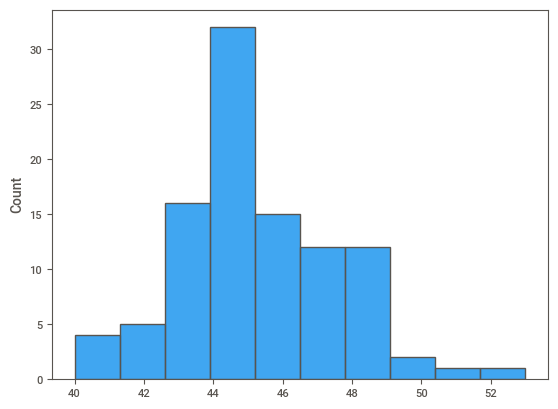

In [59]:
depths = [tree.get_depth() for tree in model_pipeline[-1].regressor_.estimators_]

sns.histplot(depths);

In [63]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = RandomForestRegressor(n_jobs=-1, random_state=903,
                                       min_samples_leaf= 2, min_samples_split=2,
                                       max_depth=45)

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [64]:
score_training = round(model_pipeline.score(X_train, y_train),2)

score_testing = round(model_pipeline.score(X_test, y_test),2)

score_training, score_testing

(0.89, 0.86)

In [72]:
# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mape = metrics.mean_absolute_percentage_error(y_pred, y_test)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAe is ${median_ae:,.2f}\n'
      f'The MAPE is {mape:,.2%}')

The MAE is $9.11
The MedAe is $3.61
The MAPE is 13.66%


In [19]:
# Calculate permutation importances
result = permutation_importance(model_pipeline,
                                X_test, y_test,
                                scoring = 'neg_median_absolute_error',
                                random_state=42,
                                n_jobs=-1)

<Axes: xlabel='Importance', ylabel='Feature'>

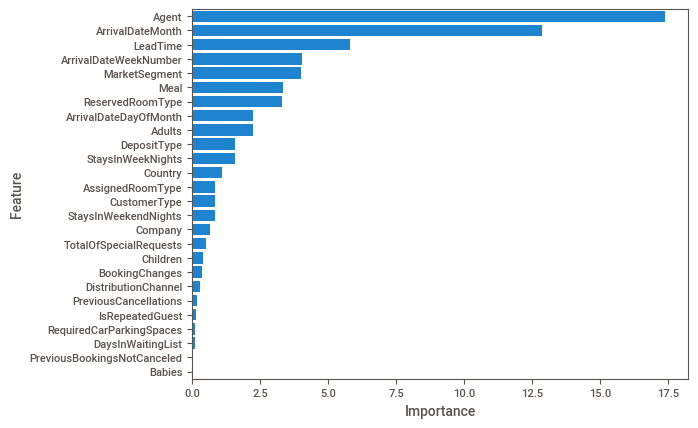

In [20]:
# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df)

In [21]:
raise Exception('End of Testing')

Exception: End of Testing

## DummyRegressor

In [ ]:
create_and_test_bl_model(X_train,y_train, X_test, y_test, DummyRegressor(random_state = 903))

In [ ]:
create_and_test_bl_model(X_train,y_train, X_test, y_test,
                         HistGradientBoostingRegressor(random_state = 903))

In [ ]:
rfr_model = create_and_test_bl_model(X_train,y_train, X_test, y_test, 
                                     RandomForestRegressor(n_jobs = -1,
                                                           min_samples_split=2,
                                                           max_depth=75))

In [ ]:
depths = [tree.get_depth() for tree in rfr_model[-1].estimators_]

sns.histplot(depths);

In [ ]:
rfr_model[-1]

In [ ]:
rfr_model[-1].feature_importances_

## SGDRegressor

In [ ]:
# ### ---  Creating ColumnTransformer and sub-transformers for imputation and encoding --- ###
# num_cols = X.select_dtypes('number').columns
# cat_cols = X.select_dtypes('object').columns

# cat_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
#                            ('ohe',
#                             OneHotEncoder(drop = 'if_binary',
#                                           handle_unknown='ignore',
#                                           sparse_output=False))])

# num_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
#                            ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
#                                                ('cat', cat_pipe, cat_cols)])

# # Integrating the preprocessor with the SGDRegressor into a pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', SGDRegressor(loss='huber',
#                                                       penalty='elasticnet',
#                                                       random_state=903))])

# pipeline.fit(X_train, y_train)


# preds = pipeline.predict(X_test)
# mae = metrics.mean_absolute_error(y_test, preds)
# rmse = metrics.root_mean_squared_error(y_test, preds)
# r2 = metrics.r2_score(y_test, preds)

# print(f'\nThe MAE is: {mae:.2f}',
#       f'\nThe RMSE is: {rmse:.2f}'
#       f'\nThe R2 is: {r2:.2f}')

# XGBRegressor

In [ ]:
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))])

# # Fit the pipeline to the training data
# pipeline.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = pipeline.predict(X_test)

# # Evaluate the model
# mae = metrics.mean_absolute_error(y_test, y_pred)
# mse = metrics.mean_squared_error(y_test, y_pred)
# r2 = metrics.r2_score(y_test, y_pred)

# # Print the results
# print(f"Mean Absolute Error (MAE): {mae:,.2f}",)
# print(f"Mean Squared Error (MSE): {mse:,.2f}",)
# print(f"R-squared (R²): {r2:,.2f}")

# Results

---

The best model was the Random Forest Regressor model, with an MAE of # and R^2 of #. This model performed well with minor pre-processing, leading me to believe there may be features that are strongly predictive of the ADR. I will need to investigate further to confirm.

---